In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
# Loading your IBM Q account(s)
provider = IBMQ.load_account()

In [2]:
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np

# We import the tools to handle general Graphs
import networkx as nx

# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram

/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


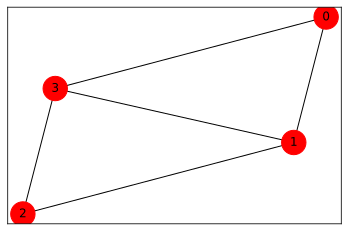

In [3]:
# Generating the butterfly graph with 5 nodes 
n     = 4
V     = np.arange(0,n,1)
E     =[(0,1,1.0),(1,2,1.0),(1,3,1.0),(2,3,1.0),(0,3,1.0)] 

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)

# Generate plot of the Graph
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

[3]


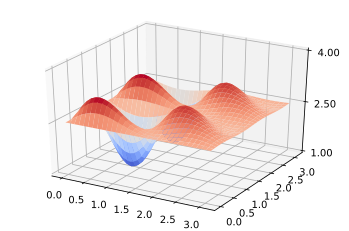


 --- OPTIMAL PARAMETERS --- 

The maximal expectation value is:  M1 = 3.235
This is attained for gamma = 0.570 and beta = 0.310


In [14]:
# Evaluate the function
step_size   = 0.1;

a_gamma         = np.arange(0, np.pi, step_size)
a_beta          = np.arange(0, np.pi, step_size)
a_gamma, a_beta = np.meshgrid(a_gamma,a_beta)
#F1 =0.5*(5+ 8*((np.cos(0.5*a_gamma))**2)*(np.cos(0.5*(a_gamma+4*a_beta)))*(np.sin(1.5*a_gamma)-np.sin(0.5*a_gamma))*np.sin(2*a_beta)-0.5*((np.sin(2*a_gamma))**2)*((np.sin(2*a_beta))**2)+((np.cos(a_gamma))**2)*np.sin(a_gamma)*np.sin(4*a_beta))
#F1 = 8*np.cos(0.5*a_gamma)*2*np.cos(0.5(a_gamma+4*a_beta))(np.sin(1.5*a_gamma)-np.sin(0.5*a_gamma))*np.sin(2*a_beta)
# Grid search for the minimizing variables
F1 = (1/32)*(78 - 8*np.cos(a_gamma) + 8*np.cos(3*a_gamma) + 2*np.cos(4*a_gamma) + 10*np.cos(a_gamma - 4*a_beta) + 
   2*np.cos(3*a_gamma - 4*a_beta) + 8*np.cos(2*(a_gamma - 2*a_beta)) - np.cos(4*(a_gamma - a_beta)) + 
   2*np.cos(4*a_beta) - np.cos(4*(a_gamma + a_beta)) - 8*np.cos(2*(a_gamma + 2*a_beta)) - 
   2*np.cos(a_gamma + 4*a_beta) - 10*np.cos(3*a_gamma + 4*a_beta))
result = np.where(F1 == np.amax(F1))
print(result[0])
a      = list(zip(result[0],result[1]))[0]

#gamma  = a[0]*step_size;
#beta   = a[1]*step_size;
gamma , beta = 0.5700000000000001, 0.31

# Plot the expetation value F1
fig = plt.figure()
ax  = fig.gca(projection='3d')

surf = ax.plot_surface(a_gamma, a_beta, F1, cmap=cm.coolwarm, linewidth=0, antialiased=True)

ax.set_zlim(1,4)
ax.zaxis.set_major_locator(LinearLocator(3))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

plt.show()

#The smallest parameters and the expectation can be extracted
print('\n --- OPTIMAL PARAMETERS --- \n')
print('The maximal expectation value is:  M1 = %.03f' % np.amax(F1))
print('This is attained for gamma = %.03f and beta = %.03f' % (gamma,beta))

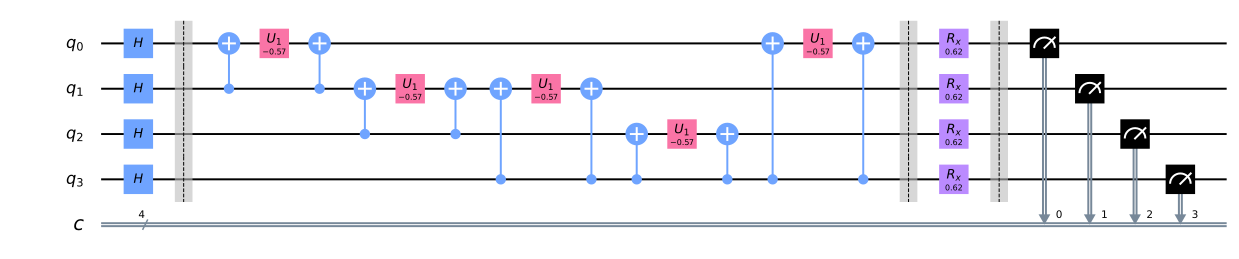

In [15]:
# prepare the quantum and classical resisters
QAOA = QuantumCircuit(len(V), len(V))

# apply the layer of Hadamard gates to all qubits
QAOA.h(range(len(V)))
QAOA.barrier()

# apply the Ising type gates with angle gamma along the edges in E
for i in range (1):

    for edge in E:
        k = edge[0]
        l = edge[1]
        QAOA.cx( l, k)
        QAOA.u1(-gamma, k)
        QAOA.cx( l, k)
    QAOA.barrier()
    QAOA.rx(2*beta, range(len(V)))



# Finally measure the result in the computational basis
QAOA.barrier()
QAOA.measure(range(len(V)),range(len(V)))

### draw the circuit for comparison
QAOA.draw(output='mpl')

In [16]:
# Compute the value of the cost function
def cost_function_C(x,G):
    
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
        
    return C

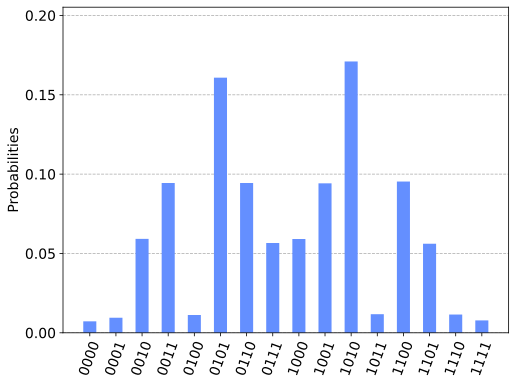

In [17]:
# run on local simulator
backend      = Aer.get_backend("qasm_simulator")
shots        = 10000

simulate     = execute(QAOA, backend=backend, shots=shots)
QAOA_results = simulate.result()

plot_histogram(QAOA_results.get_counts(),figsize = (8,6),bar_labels = False)


 --- SIMULATION RESULTS ---

The sampled mean value is M1_sampled = 3.06 while the true value is M1 = 3.24 

The approximate solution is x* = 1010 with C(x*) = 4 

The cost function is distributed as: 



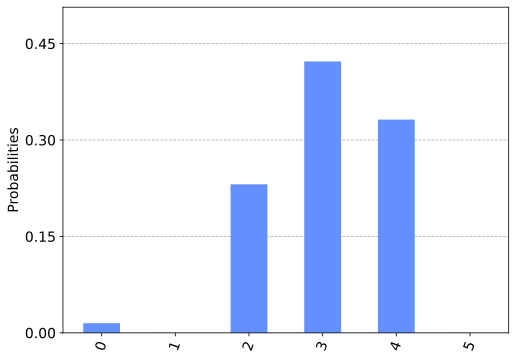

In [18]:
# Evaluate the data from the simulator
counts = QAOA_results.get_counts()

avr_C       = 0
max_C       = [0,0]
hist        = {}

for k in range(len(G.edges())+1):
    hist[str(k)] = hist.get(str(k),0)

for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
    x         = [int(num) for num in list(sample)]
    tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
    avr_C     = avr_C    + counts[sample]*tmp_eng
    hist[str(round(tmp_eng))] = hist.get(str(round(tmp_eng)),0) + counts[sample]
    
    # save best bit string
    if( max_C[1] < tmp_eng):
        max_C[0] = sample
        max_C[1] = tmp_eng
                
M1_sampled   = avr_C/shots

print('\n --- SIMULATION RESULTS ---\n')
print('The sampled mean value is M1_sampled = %.02f while the true value is M1 = %.02f \n' % (M1_sampled,np.amax(F1)))
print('The approximate solution is x* = %s with C(x*) = %d \n' % (max_C[0],max_C[1]))
print('The cost function is distributed as: \n')
plot_histogram(hist,figsize = (8,6),bar_labels = False)